In [16]:
import numpy as np
import sys
from scipy import special
from scipy import optimize
import math
from scipy.io import savemat
from numba import jit
from numba import vectorize
from numba import cuda
from scipy import integrate
from tqdm import tqdm
import matplotlib.pyplot as plt
from numba import njit, types
import vegas
from mpi4py import MPI
from scipy import optimize
%matplotlib widget

gamma0=np.array([[1,0,0,0],
                 [0,1,0,0],
                 [0,0,-1,0],
                 [0,0,0,-1]],dtype=np.complex128)

gamma1=np.array([[0,0,0,1],
                 [0,0,1,0],
                 [0,-1,0,0],
                 [-1,0,0,0]],dtype=np.complex128)

gamma2=np.array([[0,0,0,-1j],
                 [0,0,1j,0],
                 [0,1j,0,0],
                 [-1j,0,0,0]],dtype=np.complex128)

gamma3=np.array([[0,0,1,0],
                 [0,0,0,-1],
                 [-1,0,0,0],
                 [0,1,0,0]],dtype=np.complex128)

me=0.511
alpha=1/137
e=np.sqrt(4*np.pi*alpha)
Z=29
Me=me*np.array([[1.0,0,0,0],[0,1.0,0,0],[0,0,1.0,0],[0,0,0,1.0]])

In [17]:
@jit(types.float64(types.float64,types.float64),nopython=True)
def my_angle(x,y):
    res=np.angle(x+1j*y)
    if res>=0:
        return res
    else:
        return 2*np.pi+res

LOOKUP_TABLE = np.array([
    1, 1, 2, 6, 24, 120, 720, 5040, 40320,
    362880, 3628800, 39916800, 479001600,
    6227020800, 87178291200, 1307674368000,
    20922789888000, 355687428096000, 6402373705728000,
    121645100408832000, 2432902008176640000], dtype='int64')

@jit(nopython=True)
def fast_factorial(n):
    if n > 20:
        raise ValueError
    return LOOKUP_TABLE[n]


@jit(nopython=True)
def Cartesian2Spherical(px,py,pz):
    p=np.sqrt(px**2+py**2+pz**2)
    pp=np.sqrt(px**2+py**2) ##Positive Definite
    Polar=my_angle(pz,pp)
    Azimuth=my_angle(px,py)
    return p,Polar,Azimuth

@jit(nopython=True)
def angle_vector(p1x,p1y,p1z,p2x,p2y,p2z):

    p1=np.array([p1x,p1y,p1z])
    p2=np.array([p2x,p2y,p2z])

    p1_norm=p1/np.sqrt(p1x**2+p1y**2+p1z**2)
    p2_norm=p2/np.sqrt(p2x**2+p2y**2+p2z**2)

    vx= p1_norm+p2_norm
    vy= p1_norm-p2_norm

    x=np.sqrt(vx[0]**2+vx[1]**2+vx[2]**2)
    y=np.sqrt(vy[0]**2+vy[1]**2+vy[2]**2)

    return 2*np.arctan2(y,x)

@jit(nopython=True)
def slash(p):
    return p[0]*gamma0-p[1]*gamma1-p[2]*gamma2-p[3]*gamma3

@jit(nopython=True)
def product(x,y):
    return x[0]*y[0]-x[1]*y[1]-x[2]*y[2]-x[3]*y[3]


@jit(types.complex128[::1](types.float64[:],types.float64),nopython=True)
def spin_u(fvp,spin):
    if spin > 0:
        part1=np.sqrt(fvp[0]+me)
        part2=0
        part3=fvp[3]/np.sqrt(fvp[0]+me)
        part4=(fvp[1]+1j*fvp[2])/np.sqrt(fvp[0]+me)  
    if spin < 0:
        part1=0
        part2=np.sqrt(fvp[0]+me)
        part3=(fvp[1]-1j*fvp[2])/np.sqrt(fvp[0]+me)
        part4=(-fvp[3])/np.sqrt(fvp[0]+me)
  
    res=np.array([part1,part2,part3,part4],dtype=np.complex128)

    return res

@jit(types.complex128[::1](types.float64[:],types.float64),nopython=True)
def spin_baru(fvp,spin):
    if spin > 0:
        part1=np.sqrt(fvp[0]+me)
        part2=0
        part3=-fvp[3]/np.sqrt(fvp[0]+me)
        part4=-(fvp[1]-1j*fvp[2])/np.sqrt(fvp[0]+me)  
    if spin < 0:
        part1=0
        part2=np.sqrt(fvp[0]+me)
        part3=-(fvp[1]+1j*fvp[2])/np.sqrt(fvp[0]+me)
        part4=(fvp[3])/np.sqrt(fvp[0]+me)
  
    res=np.array([part1,part2,part3,part4],dtype=np.complex128)

    return res

right=-1
left=1
@jit(types.complex128[::1](types.float64,types.float64,types.float64),nopython=True)
def polarize(theta,phi,lambdap):
    return (lambdap/np.sqrt(2))*np.array([0,-np.cos(theta)*np.cos(phi)+1j*lambdap*np.sin(phi),\
                                         -np.cos(theta)*np.sin(phi)-1j*lambdap*np.cos(phi),np.sin(theta)])

@jit(types.complex128[::1](types.float64,types.float64,types.float64),nopython=True)
def conj_polarize(theta,phi,lambdap):
    return (lambdap/np.sqrt(2))*np.array([0,-np.cos(theta)*np.cos(phi)-1j*lambdap*np.sin(phi),\
                                         -np.cos(theta)*np.sin(phi)+1j*lambdap*np.cos(phi),np.sin(theta)])

In [18]:
@jit(types.complex128(types.float64[:],types.float64,types.float64[:],types.float64,types.float64[:],types.float64),nopython=True)
def InvariantM(fvp0,spinp0,fvk1,spink1,fvp1,spinp1):

    k1,thetak1,phik1=Cartesian2Spherical(fvk1[1],fvk1[2],fvk1[3])
    num1=spin_baru(fvp1,spinp1)@slash(conj_polarize(thetak1,phik1,spink1))@(slash(fvp1)+slash(fvk1)+Me)@gamma0@spin_u(fvp0,spinp0)
    num2=spin_baru(fvp1,spinp1)@gamma0@(slash(fvp0)-slash(fvk1)+Me)@slash(conj_polarize(thetak1,phik1,spink1))@spin_u(fvp0,spinp0)

    qsquare=(fvp0[1]-fvk1[1]-fvp1[1])**2+(fvp0[2]-fvk1[2]-fvp1[2])**2+(fvp0[3]-fvk1[3]-fvp1[3])**2
    deno1=product(fvk1+fvp1,fvk1+fvp1)-me**2
    deno2=product(fvp0-fvk1,fvp0-fvk1)-me**2

    part1=num1/deno1
    part2=num2/deno2
    res=(-Z*e**3/qsquare)*(part1+part2)

    return res

@jit(nopython=True)
def LGpacket(kx,ky,kz,l,k0,sigmap,sigmaz,bx,by):
    al=np.abs(l)
    energy=np.sqrt(kx**2+ky**2+kz**2+me**2)
    kp=np.sqrt(kx**2+ky**2)
    phikp=my_angle(kx,ky)
    norm_constant=(4*np.pi)**(3/4)*sigmap*np.sqrt(sigmaz)*np.sqrt(2*energy)
    # norm_constant=1
    res=norm_constant*((sigmap*kp)**al/np.sqrt(fast_factorial(al)))*\
        np.exp(-(kp*sigmap)**2/2)*np.exp(-(kz-k0)**2*sigmaz**2/2)*np.exp(1j*l*phikp)
    
    space_delay=np.exp(-1j*bx*kx-1j*by*ky)

    return res*space_delay

In [19]:
@njit(types.complex128(types.float64,types.float64,types.float64[:],types.float64[:],types.int64,types.float64,\
                       types.float64,types.float64,types.float64,types.float64,types.float64,types.float64,types.float64))
def Integrand_Amp(thetap0,phip0,fvk1,fvp1,l,p0,sigmap0,sigmaz0,bx,by,spinp0,spink1,spinp1):
    Ep=fvk1[0]+fvp1[0]
    p=np.sqrt(Ep**2-me**2)
    px=p*np.sin(thetap0)*np.cos(phip0)
    py=p*np.sin(thetap0)*np.sin(phip0)
    pz=p*np.cos(thetap0)

    part_LG=LGpacket(px,py,pz,l,p0,sigmap0,sigmaz0,bx,by)

    fvp0=np.array([Ep,px,py,pz])

    InvM=InvariantM(fvp0,spinp0,fvk1,spink1,fvp1,spinp1)

    res=(p*np.pi*np.sin(thetap0)/((2*np.pi)**3))*part_LG*InvM
    return res


In [20]:
nm=5000.0
sigmap0=0.2*nm
sigmaz0=0.1*nm
p0=5
l=10

Ep1=3.026
thetap1=np.pi/2
phip1=np.pi/3
p1=np.sqrt(Ep1**2-me**2)
fvp1=np.array([Ep1,p1*np.sin(thetap1)*np.cos(phip1),p1*np.sin(thetap1)*np.sin(phip1),p1*np.cos(thetap1)])

Ek1=2
thetak1=np.pi/3
phik1=np.pi/3
fvk1=np.array([Ek1,Ek1*np.sin(thetak1)*np.cos(phik1),Ek1*np.sin(thetak1)*np.sin(phik1),Ek1*np.cos(thetak1)])



thetap0=np.linspace(0,0.0015,100)
phip0=np.linspace(0,2*np.pi,200)

res1=np.zeros((np.size(thetap0),np.size(phip0)),dtype=np.complex128)
res2=np.zeros((np.size(thetap0),np.size(phip0)),dtype=np.complex128)
for i in tqdm(np.arange(np.size(thetap0))):
    for j in np.arange(np.size(phip0)):
        res1[i,j]=Integrand_Amp(thetap0[i],phip0[j],fvk1,fvp1,l,p0,sigmap0,sigmaz0,0,0.6*nm,0.5,1.0,0.5)
        res2[i,j]=Integrand_Amp(thetap0[i],phip0[j],fvk1,fvp1,l,p0,sigmap0,sigmaz0,0.6*nm,0,0.5,1.0,0.5)

yty=integrate.trapezoid(res1,x=phip0,dx=phip0[1]-phip0[0],axis=1)
intresy=integrate.trapezoid(yty,x=thetap0,dx=thetap0[1]-thetap0[0],axis=0)

ytx=integrate.trapezoid(res2,x=phip0,dx=phip0[1]-phip0[0],axis=1)
intresx=integrate.trapezoid(ytx,x=thetap0,dx=thetap0[1]-thetap0[0],axis=0)

print(intresy,intresx)

100%|██████████| 100/100 [00:00<00:00, 635.49it/s]

(-0.0005881358803149532+2.1885263852757467e-07j) (0.0005870557782510165-1.260840577325151e-07j)


In [21]:
the_up=0.0015
theta_mesh=100
phi_mesh=200

@jit(nopython=True)
def Moller_SqIMatrix(p1x,p1y,p1z,k1x,k1y,k1z,l,p0,sigmap0,sigmaz0,spinp0,spink1,spinp1,bx,by):   
    fvk1=np.array([np.sqrt(k1x**2+k1y**2+k1z**2),k1x,k1y,k1z])
    fvp1=np.array([np.sqrt(p1x**2+p1y**2+p1z**2+me**2),p1x,p1y,p1z])
    #################################### generate trapezoid integrate matrix#####################################################
    thetak1,phik1=np.linspace(0,the_up,theta_mesh),np.linspace(0,2*np.pi,phi_mesh)
    res_matrix=np.zeros((theta_mesh,phi_mesh),dtype=np.complex128)

    for i in np.arange(0,theta_mesh):
        for j in np.arange(0,phi_mesh):
            res_matrix[i,j]=Integrand_Amp(thetap0[i],phip0[j],fvk1,fvp1,l,p0,sigmap0,sigmaz0,bx,by,spinp0,spink1,spinp1)
            
    return res_matrix


In [22]:
def test(fvp1,fvk1,bx,by,spinp0,spink1,spinp1):
    p1x,p1y,p1z=fvp1[1],fvp1[2],fvp1[3]
    k1x,k1y,k1z=fvk1[1],fvk1[2],fvk1[3]
    res_matrix=Moller_SqIMatrix(p1x,p1y,p1z,k1x,k1y,k1z,l,p0,sigmap0,sigmaz0,spinp0,spink1,spinp1,bx,by)

    yt=integrate.trapezoid(res_matrix,x=phip0,dx=phip0[1]-phip0[0],axis=1)
    intres=integrate.trapezoid(yt,x=thetap0,dx=thetap0[1]-thetap0[0],axis=0)

    return np.abs(intres)

In [25]:
b=np.linspace(0,1.6*nm,100)
resx=np.zeros(np.size(b))
resy=np.zeros(np.size(b))

for i in tqdm(np.arange(np.size(b))):
    resx[i]=test(fvp1,fvk1,b[i],0,0.5,1,0.5)
    resy[i]=test(fvp1,fvk1,0,b[i],0.5,1,0.5)

100%|██████████| 100/100 [00:09<00:00, 10.74it/s]


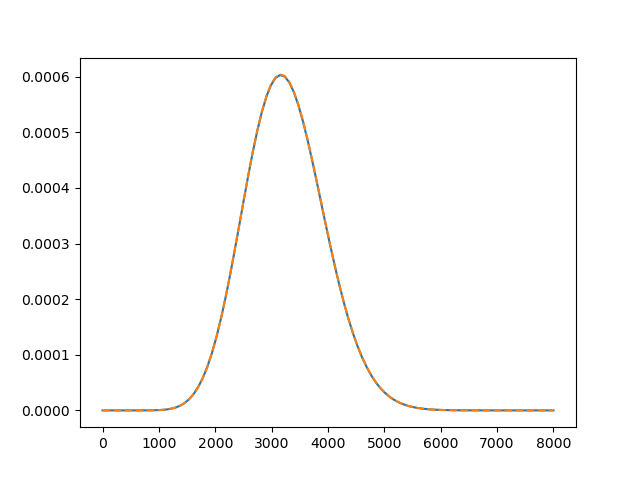

In [26]:
fig,ax=plt.subplots()
ax.plot(b,resx)
ax.plot(b,resy,'--')

In [28]:
y_real=integrate.dblquad(lambda thetap0,phip0: np.real(Integrand_Amp(thetap0,phip0,fvk1,fvp1,l,p0,sigmap0,sigmaz0,0,0.62*nm,0.5,1.0,0.5)),0,2*np.pi,0,0.0025)[0]
y_imag=integrate.dblquad(lambda thetap0,phip0: np.imag(Integrand_Amp(thetap0,phip0,fvk1,fvp1,l,p0,sigmap0,sigmaz0,0,0.62*nm,0.5,1.0,0.5)),0,2*np.pi,0,0.0025)[0]

x_real=integrate.dblquad(lambda thetap0,phip0: np.real(Integrand_Amp(thetap0,phip0,fvk1,fvp1,l,p0,sigmap0,sigmaz0,0.62*nm,0,0.5,1.0,0.5)),0,2*np.pi,0,0.0025)[0]
x_imag=integrate.dblquad(lambda thetap0,phip0: np.imag(Integrand_Amp(thetap0,phip0,fvk1,fvp1,l,p0,sigmap0,sigmaz0,0.62*nm,0,0.5,1.0,0.5)),0,2*np.pi,0,0.0025)[0]

print(y_real+1j*y_imag)
print(x_real+1j*x_imag)

(-0.0006017559378417785+2.598620967622572e-07j)
(0.000600658843219259-1.4970315387586545e-07j)


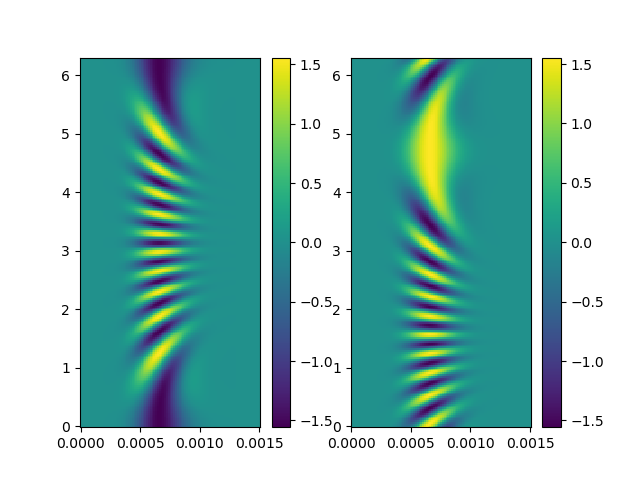

In [11]:
fig,ax=plt.subplots(1,2)
pm0=ax[0].pcolor(thetap0,phip0,np.real(res1).T)
fig.colorbar(pm0)

pm1=ax[1].pcolor(thetap0,phip0,np.real(res2).T)
fig.colorbar(pm1)